Importation des librairies utiles

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from math import ceil
import concurrent.futures as cf
import pandas as pd
import json
import matplotlib.pyplot as plt
import requests
import re

N'ayant pas besoin d'intéragir avec les éléments de la page, le module requests aurait été suffisant et même plus efficace. Cependant le site du gouvernement est protégé par Incapsula contre le scraping, il est donc nécessaire d'utiliser Selenium qui utilise un vrai navigateur (mais qui est donc plus lent). 

In [2]:
def getDriver():
    options = webdriver.ChromeOptions()
    options.binary_location = "C:\\Program Files\\BraveSoftware\\Brave-Browser\\Application\\brave.exe"
    options.add_argument("--headless")
    return webdriver.Chrome(chrome_options=options, executable_path="C:\\Windows\\chromedriver.exe")

Fonction permettant de trouver l'année dans une phrase

In [3]:
def extractYear(sentence):
    ys = [str(y) for y in range(1946, 2024)]
    for y in ys:
        if (sentence.find(y) > 0):
            return int(y)

Fonction qui scrap les informations utiles (lien et année), page par page

In [4]:
def retrieve(url):
    to_add = []
    dr = getDriver()
    dr.get(url)
    articles = dr.find_elements(By.CLASS_NAME, "result-item")
    for article in articles:
        a = article.find_element(By.TAG_NAME, 'a')
        link = a.get_attribute("href")
        title = a.get_attribute("innerText")
        to_add.append((link, extractYear(title)))
    dr.quit()
    return to_add

Code qui récupére réelement les liens et années. 10 navigateurs sont lancés en paralèlle pour accélérer le processus. Les résultats sont finalement enregistrés dans un fichier json

In [ ]:
for annee in range(1947, 2024):
   base_url = f"https://www.legifrance.gouv.fr/search/juri?tab_selection=juri&searchField=ALL&query=*&searchType=ALL&dateDecision=01%2F01%2F{annee}+%3E+01%2F01%2F{annee+1}&cassPubliBulletin=T&cassPubliBulletin=F&cassDecision=ARRET&cassFormation=ASSEMBLEE_PLENIERE&cassFormation=CHAMBRE_MIXTE&cassFormation=CHAMBRES_REUNIES&cassFormation=CHAMBRE_CIVILE_1&cassFormation=CHAMBRE_CIVILE_2&cassFormation=CHAMBRE_CIVILE_3&cassFormation=CHAMBRE_COMMERCIALE&cassFormation=CHAMBRE_SOCIALE&cassFormation=CHAMBRE_CRIMINELLE&cassFormation=COMMISSION_REEXAMEN&cassFormation=COMMISSION_REPARATION_DETENTION&cassFormation=COMMISSION_REVISION&cassFormation=COUR_REVISION&cassFormation=JURIDICTION_NATIONALE_LIBERTE_CONDITIONNELLE&cassFormation=ORDONNANCE_PREMIER_PRESIDENT&cassDecisionAttaquee=COMMISSION_INDEMNISATION_VICTIMES_INFRACTIONS&cassDecisionAttaquee=CONSEIL_PRUDHOMME&cassDecisionAttaquee=COUR_APPEL&cassDecisionAttaquee=COUR_ASSISES&cassDecisionAttaquee=COUR_CASSATION&cassDecisionAttaquee=COUR_JUSTICE_REPUBLIQUE&cassDecisionAttaquee=COUR_NATIONAL_INCAPACITE_TARIFICATION&cassDecisionAttaquee=TRIBUNAL_CORRECTIONNEL&cassDecisionAttaquee=TRIBUNAL_COMMERCE&cassDecisionAttaquee=TRIBUNAL_GRANDE_INSTANCE&cassDecisionAttaquee=TRIBUNAL_POLICE&cassDecisionAttaquee=TRIBUNAL_PREMIERE_INSTANCE&cassDecisionAttaquee=TRIBUNAL_AFFAIRES_SECURITE_SOCIALE&cassDecisionAttaquee=TRIBUNAL_FORCES_ARMEES&cassDecisionAttaquee=TRIBUNAL_INSTANCE&cassDecisionAttaquee=TRIBUNAL_CONTENTIEUX_INCAPACITE&cassDecisionAttaquee=TRIBUNAL_MARITIME_COMMERCIAL&cassDecisionAttaquee=TRIBUNAL_PARITAIRE_BAUX_RURAUX&cassDecisionAttaquee=TRIBUNAL_SUPERIEURS_APPEL&juridictionJudiciaire=Cour+de+cassation&typePagination=DEFAULT&sortValue=DATE_ASC&pageSize=100&page=1&tab_selection=juri#juri"
   driver = getDriver()
   driver.get(base_url)
   number_pattern = r'\d+'
   nb_pages_string = driver.find_element(By.CLASS_NAME, "nb-result").get_attribute("innerHTML")
   nb_pages = ceil(int(re.findall(number_pattern, nb_pages_string)[0])/100)
   driver.quit()
   pages = [f"https://www.legifrance.gouv.fr/search/juri?tab_selection=juri&searchField=ALL&query=*&searchType=ALL&dateDecision=01%2F01%2F{annee}+%3E+01%2F01%2F{annee+1}&cassPubliBulletin=T&cassPubliBulletin=F&cassDecision=ARRET&cassFormation=ASSEMBLEE_PLENIERE&cassFormation=CHAMBRE_MIXTE&cassFormation=CHAMBRES_REUNIES&cassFormation=CHAMBRE_CIVILE_1&cassFormation=CHAMBRE_CIVILE_2&cassFormation=CHAMBRE_CIVILE_3&cassFormation=CHAMBRE_COMMERCIALE&cassFormation=CHAMBRE_SOCIALE&cassFormation=CHAMBRE_CRIMINELLE&cassFormation=COMMISSION_REEXAMEN&cassFormation=COMMISSION_REPARATION_DETENTION&cassFormation=COMMISSION_REVISION&cassFormation=COUR_REVISION&cassFormation=JURIDICTION_NATIONALE_LIBERTE_CONDITIONNELLE&cassFormation=ORDONNANCE_PREMIER_PRESIDENT&cassDecisionAttaquee=COMMISSION_INDEMNISATION_VICTIMES_INFRACTIONS&cassDecisionAttaquee=CONSEIL_PRUDHOMME&cassDecisionAttaquee=COUR_APPEL&cassDecisionAttaquee=COUR_ASSISES&cassDecisionAttaquee=COUR_CASSATION&cassDecisionAttaquee=COUR_JUSTICE_REPUBLIQUE&cassDecisionAttaquee=COUR_NATIONAL_INCAPACITE_TARIFICATION&cassDecisionAttaquee=TRIBUNAL_CORRECTIONNEL&cassDecisionAttaquee=TRIBUNAL_COMMERCE&cassDecisionAttaquee=TRIBUNAL_GRANDE_INSTANCE&cassDecisionAttaquee=TRIBUNAL_POLICE&cassDecisionAttaquee=TRIBUNAL_PREMIERE_INSTANCE&cassDecisionAttaquee=TRIBUNAL_AFFAIRES_SECURITE_SOCIALE&cassDecisionAttaquee=TRIBUNAL_FORCES_ARMEES&cassDecisionAttaquee=TRIBUNAL_INSTANCE&cassDecisionAttaquee=TRIBUNAL_CONTENTIEUX_INCAPACITE&cassDecisionAttaquee=TRIBUNAL_MARITIME_COMMERCIAL&cassDecisionAttaquee=TRIBUNAL_PARITAIRE_BAUX_RURAUX&cassDecisionAttaquee=TRIBUNAL_SUPERIEURS_APPEL&juridictionJudiciaire=Cour+de+cassation&typePagination=DEFAULT&sortValue=DATE_ASC&pageSize=100&page={i}&tab_selection=juri#juri" for i in range(1, min(100, nb_pages+1))]
   with cf.ThreadPoolExecutor(max_workers=10) as executor:
      futures = [executor.submit(retrieve, url) for url in pages]
      for future in cf.as_completed(futures):
         try:
            results = [future.result() for future in futures]
            with open(f"data_{annee}.json", "w") as json_file:
               json.dump(results, json_file)
         except requests.ConnectTimeout:
            pass

Formatage des datas dans un DataFrame pandas

In [7]:
to_concat = []
for year in range(1947, 2024):
    if not year == 1952:
        with open(f"data_{year}.json", "r") as json_file:
            data = json.load(json_file)
        data = [sub for sub in data if len(sub) > 0]
        flat = []
        for sub in data:
            for item in sub:
                flat.append(item)
        df = pd.DataFrame(flat, columns=['url', 'year'])
        to_concat.append(df.sample(n = min(100, len(df)), random_state = 42))

On se limite à maximum 100 données par an

In [8]:
normalized = pd.concat(to_concat, axis=0).reset_index(drop=True)

On va maintenant scraper les liens des jugements que nous avons gardés pour en retirer les informations qui nous intéressent:
- Date exacte
- Sexe du président
- Juridiction

Le multithreading est utilisé ici aussi

In [33]:
def retrieve2(url):
    res = {'date': '', 'gender': '', 'juridiction': ''}
    driver = getDriver()
    patternF = r"Mme "
    patternM = r"M\.|M "
    patternDate = r"\b\d{1,2}\s+(?:janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre)\s+\d{4}\b"
    driver.get(url)
    try:
        juridiction = driver.find_elements(By.CLASS_NAME, "horsAbstract")[0]\
                            .get_attribute("innerText")
        juridiction = juridiction[juridiction.find("- ")+2:]
    except Exception as e:
        juridiction = ''
        print("An error occurred:", str(e))
    try:
        pdt = driver.find_elements(By.CLASS_NAME, 'frame-block')[1]\
              .find_elements(By.TAG_NAME,'div')[0]\
              .find_elements(By.TAG_NAME, 'dd')[0]\
              .get_attribute("innerText")
        if re.findall(patternF, pdt, re.IGNORECASE):
            gender = 'F'
        elif re.findall(patternM, pdt, re.IGNORECASE):
            gender = 'M'
        else:
            gender = ''
    except Exception as e:
        gender = ''
        print("An error occurred:", str(e))
    try:
        date = driver.find_elements(By.CLASS_NAME, "horsAbstract")[1]\
                            .get_attribute("innerText")
        date = re.findall(patternDate, date, re.IGNORECASE)[0]
    except Exception as e:
        date = ''
        print("An error occurred:", str(e))
    driver.quit()
    res['date'] = date
    res['gender'] = gender
    res['juridiction'] = juridiction
    return res

In [ ]:
with cf.ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(retrieve2, url) for url in normalized[normalized['year'] >= 1973]['url']]
    for future in cf.as_completed(futures):
        try:
            results = [future.result() for future in futures]
            with open(f"final_data.json", "w") as json_file:
                json.dump(results, json_file)
        except requests.ConnectTimeout:
            pass

In [40]:
results

,date,gender,juridiction
0,04 avril 1973,M,Chambre civile 2
1,13 novembre 1973,M,Chambre criminelle
2,14 février 1973,M,Chambre commerciale
3,03 décembre 1973,M,Chambre commerciale
4,14 février 1973,M,Chambre civile 3
...,...,...,...
5095,01 mars 2023,M,Chambre commerciale
5096,15 février 2023,M,Chambre commerciale
5097,18 janvier 2023,F,Chambre sociale
5098,25 janvier 2023,F,Chambre civile 3


Les résultats sont mis en forme dans un DataFrame puis sont sauvés dans un fichier csv

In [39]:
results = pd.DataFrame(results)
results.to_csv("dataframe.csv", index=False)

Il y aurait 565 femmes qui ont présidé entre 1973 et 2023

In [41]:
results[results['gender'] == 'F']

,date,gender,juridiction
1213,25 octobre 1985,F,Assemblée plénière
1364,28 février 1986,F,Chambre mixte
2759,18 janvier 2000,F,Chambre civile 1
2975,15 mai 2002,F,Chambre civile 3
3127,12 octobre 2004,F,Chambre sociale
...,...,...,...
5088,18 janvier 2023,F,Chambre civile 3
5092,11 janvier 2023,F,Chambre civile 3
5094,16 mars 2023,F,Chambre civile 3
5097,18 janvier 2023,F,Chambre sociale


On se rend compte qu'il y a beacoup de données manquantes

In [42]:
print(f"Nombre de jugements étudiés: {len(results)}\nNombre de jugements où le sexe du président est indiqué: {len(results[results['gender'] != ''])}")

Nombre de jugements étudiés: 5100
Nombre de jugements où le sexe du président est indiqué: 4619


On retire en suite les lignes vides

In [43]:
clean = results[results['gender'] != '']

Puis on convertit les dates en datetime, de sorte à avoir des time series

In [44]:
mois = {" janvier ": "/01/", " février ": "/02/", " mars ": "/03/", " avril ": "/04/", " mai ": "/05/", " juin ": "/06/", " juillet ": "/07/", " août ": "/08/", " septembre ": "/09/", " octobre ": "/10/", " novembre ": "/11/", " décembre ": "/12/"}
def convert(dt):
    for m in mois:
        if m in dt:
            return dt.replace(m, mois[m])

In [ ]:
clean.loc[:, 'date'] = clean['date'].apply(convert)
clean.loc[:, 'date'] = pd.to_datetime(clean['date'], format='%d/%m/%Y')
clean.set_index('date', inplace=True)

Enfin, on compte le nombre de femmes présidentes par année et on affiche le graphe des résultats

In [46]:
serie = clean.groupby(clean.index.year)['gender'].sum()
serie = serie.apply(lambda val: val.count('F'))

In [49]:
plt.rcParams['figure.figsize'] = [12, 8]

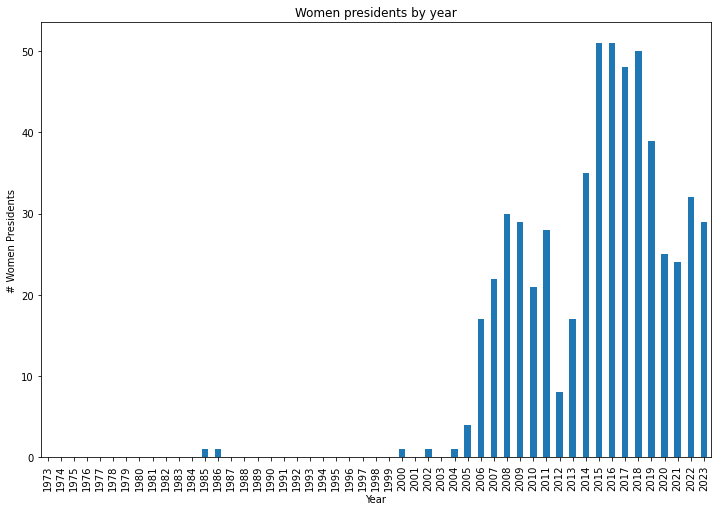

In [52]:
serie.plot.bar()
plt.xlabel('Year')
plt.ylabel('# Women Presidents')
plt.title('Women presidents by year')
plt.savefig('graph.png')
plt.show()